# **Flood Mapping with Google Earth Engine**
This notebook provides an interactive interface for rapid flood mapping using Sentinel-1 (SAR) and Sentinel-2 (Optical) satellite data via Google Earth Engine (GEE). It allows you to choose the flood detection method (SAR, Sentinel-2, or both) and export the results.

## **1. Initialization and Imports**
We start by importing the necessary libraries and initializing the Google Earth Engine API. Make sure you are authenticated with GEE before running this section.

In [1]:
import ee
import geemap
import datetime
import os
from flood_mapper import authentication, data_ingestion, preprocessing, flood_detection, visualization, utils

# Initialize Google Earth Engine
try:
    authentication.initialize_ee(project_name='ee-fid')
except Exception as e:
    print(f"Error initializing GEE: {e}")
    print("Please ensure you are authenticated and have access to the specified project.")
    # Exit if GEE initialization fails, as the rest of the notebook depends on it
    exit()

print("Notebook initialization complete.")

Google Earth Engine initialized successfully.
Notebook initialization complete.


## **2. Parameter Definition**

Define the key parameters for your flood mapping analysis here.

- `event_date_str`: The date of the flood event (format 'YYYY-MM-DD').

- `aoi_geojson_path`: Path to a GeoJSON file defining the Area of Interest (AOI). Set to None to use the default AOI (Lomé, Togo).

- `otsu_aoi_geojson_path`: Path to a GeoJSON file for Otsu threshold calculation. Set to None to use the default Lac Togo polygon (handled internally by `flood_detection.py`)

- `sar_search_days`: Number of days before/after event_date to search for Sentinel-1 images.

- `s2_search_days`: Number of days before/after event_date to search for Sentinel-2 images.

- `export_results`: Set to True to export results to GEE Assets.

- `asset_id_prefix`: Prefix for the GEE Asset ID (e.g., 'users/your_username/my_flood_maps/'). **Remember to change this!**

- `detection_method`: Flood detection method ('sar', 's2', or 'both').

In [5]:
# --- Paramètres configurables ---
event_date_str = '2025-06-02' # Date de l'événement d'inondation
aoi_geojson_path = "/home/fifi/FLOODING_Sentinel1/flood_mapper/data/Lomé_city.geojson" # Remplacez par votre chemin GeoJSON, ou None pour l'AOI par défaut
otsu_aoi_geojson_path = "/home/fifi/FLOODING_Sentinel1/flood_mapper/data/aoi_hist_region.geojson" # Remplacez par votre chemin GeoJSON pour Otsu, ou None pour l'AOI par défaut
sar_search_days = 12 # Jours de recherche pour Sentinel-1
s2_search_days = 20 # Jours de recherche pour Sentinel-2
export_results = False # True pour exporter les résultats vers les Assets GEE
asset_id_prefix = "project/ee-fid/FloodMappingResults/" # REMPLACEZ PAR VOTRE PRÉFIXE D'ASSET GEE !
detection_method = "both" # Options: 'sar', 's2', 'both'

# Convertir la date de l'événement en objet ee.Date
event_date = ee.Date(event_date_str)

# Définir l'AOI principale
if aoi_geojson_path:
    try:
        AOI = utils.load_aoi_from_geojson(aoi_geojson_path)
        print(f"Main AOI chargée depuis {aoi_geojson_path}")
    except ValueError as e:
        print(f"Erreur lors du chargement de l'AOI principale depuis GeoJSON : {e}. Utilisation de l'AOI par défaut.")
        AOI = ee.Geometry.Polygon(
            [[[0.889893, 6.110515],
              [0.889893, 6.342597],
              [1.853943, 6.342597],
              [1.853943, 6.110515],
              [0.889893, 6.110515]]]
        )
        print("Utilisation de l'AOI principale par défaut (Lomé, Togo).")
else:
    AOI = ee.Geometry.Polygon(
        [[[0.889893, 6.110515],
          [0.889893, 6.342597],
          [1.853943, 6.342597],
          [1.853943, 6.110515],
          [0.889893, 6.110515]]]
    )
    print("Aucun chemin GeoJSON d'AOI principale fourni. Utilisation de l'AOI principale par défaut (Lomé, Togo).")

# Définir l'AOI d'Otsu (si fourni, sinon passer None à flood_detection pour sa valeur par défaut)
otsu_aoi_geometry = None
if otsu_aoi_geojson_path:
    try:
        otsu_aoi_geometry = utils.load_aoi_from_geojson(otsu_aoi_geojson_path)
        print(f"AOI d'Otsu spécifique chargée depuis {otsu_aoi_geojson_path}")
    except ValueError as e:
        print(f"AVERTISSEMENT : Erreur lors du chargement de l'AOI d'Otsu spécifique depuis GeoJSON : {e}. La détection des inondations utilisera son AOI d'Otsu par défaut interne.")
        # otsu_aoi_geometry reste None, ce qui déclenchera la valeur par défaut dans flood_detection.py
else:
    print("Aucun chemin GeoJSON d'AOI d'Otsu spécifique fourni. La détection des inondations utilisera son AOI d'Otsu par défaut interne (Lac Togo).")

print(f"\nTraitement de l'événement d'inondation pour le {event_date_str} dans l'AOI principale : {AOI.getInfo()['coordinates']}")


Main AOI chargée depuis /home/fifi/FLOODING_Sentinel1/flood_mapper/data/Lomé_city.geojson
AOI d'Otsu spécifique chargée depuis /home/fifi/FLOODING_Sentinel1/flood_mapper/data/aoi_hist_region.geojson

Traitement de l'événement d'inondation pour le 2025-06-02 dans l'AOI principale : [[[1.197699562174904, 6.110970204314967], [1.7809338943232262, 6.110970204314967], [1.7809338943232262, 6.343103856706293], [1.197699562174904, 6.343103856706293], [1.197699562174904, 6.110970204314967]]]


## **3. Data Processing and Flood Detection**
This section executes the flood detection pipeline based on the chosen `detection_method`.


--- Sentinel-1 Data Processing ---
	Total Sentinel-1 images available: 4 images
    Total Sentinel-1 images selected for pre-event: 2 images
    Total Sentinel-1 images selected for post-event: 2 images
Sentinel-1 data prepared.

--- Flood Extent Detection (SAR-based) ---
Using provided Otsu AOI: [[[1.426799813031323, 6.256350133650187], [1.4355427504591773, 6.256350133650187], [1.4355427504591773, 6.267896618809445], [1.426799813031323, 6.267896618809445], [1.426799813031323, 6.256350133650187]]]
Pixel count for pre_event image: 16567632
Pixel count for post_event image: 16567683


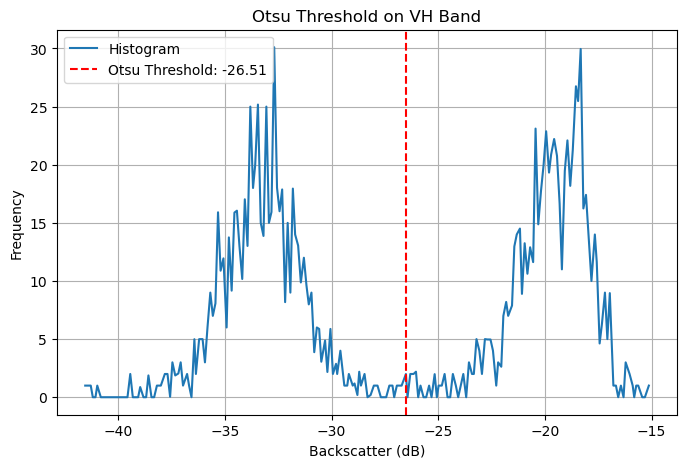

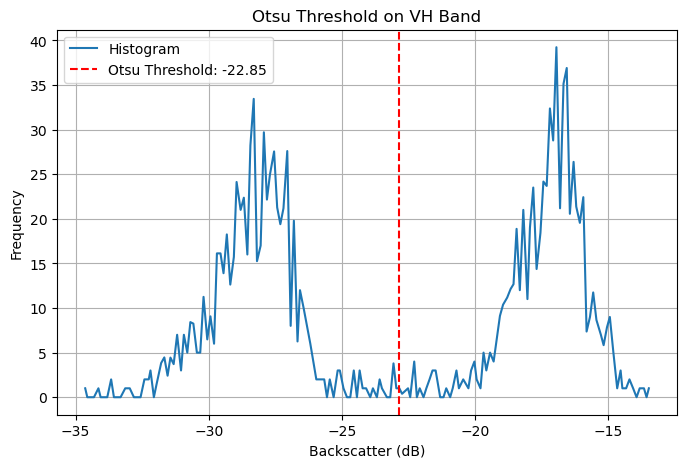

Otsu Threshold for pre-event SAR image: -26.51
Otsu Threshold for post-event SAR image: -22.85
    Refining flood extent: min_connected_pixels=8, max_slope_percent=5%
Calculated Effective Flooded Area: 3.58 km²
Calculated effective SAR-based flooded area (after refinement): 3.58 km²

---  Sentinel-2 Data Processing ---
	Total Sentinel-2 images available: 6 images
Sentinel-2 data prepared and NDWI calculated.
Pixel count for pre_event image: 16786990
Pixel count for post_event image: 16027602
    Refining flood extent: min_connected_pixels=8, max_slope_percent=5%
Calculated Effective Flooded Area: 45.04 km²
Calculated Sentinel-2 NDWI-based flooded area : 45.04 km²

EWater Area Estimates  (in km²) :
Flood Extent (Sentinel-2 NDWI) : 45.04 km²
Effective Flooded Area (SAR)  : 3.58 km²


In [6]:
sar_pre_event, sar_post_event = None, None
s2_pre_event, s2_post_event = None, None
ndwi_pre_event_mask, ndwi_post_event_mask = None, None

s1_flood_extent_image = None
s1_flooded_extend_image = None
s1_flooded_area_sqkm = 0.0

s2_flood_extent_image = None
s2_flooded_extent_image = None
s2_flooded_area_sqkm = 0.0


# --- Conditional Data Processing and Flood Detection ---

if detection_method in ["sar", "both"]:
    # --- Sentinel-1 Processing ---
    print("\n--- Sentinel-1 Data Processing ---")
    s1_start_date = event_date.advance(-sar_search_days, 'day')
    s1_end_date = event_date.advance(sar_search_days, 'day')
    try:
        s1_collection = data_ingestion.get_sentinel1_collection(AOI, s1_start_date, s1_end_date)
        sar_pre_event, sar_post_event = preprocessing.get_pre_and_post_sar_images(
            s1_collection, AOI, event_date, sar_search_days
        )
        print("Sentinel-1 data prepared.")

        # --- Flood Detection (SAR-based) ---
        print("\n--- Flood Extent Detection (SAR-based) ---")
        # Pass otsu_aoi_geometry directly
        water_pre, water_post, s1_flood_extent_image = flood_detection.detect_flood_extent(
            pre_event_sar=sar_pre_event, 
            post_event_sar=sar_post_event, 
            aoi=AOI, # Main AOI for clipping/context
            otsu_aoi=otsu_aoi_geometry # Pass the ee.Geometry directly
        )
        
        if s1_flood_extent_image: # Only refine if initial flood extent was calculated
            s1_flooded_extend_image = flood_detection.refine_flood_extent_with_topology(s1_flood_extent_image, AOI)
            s1_flooded_area_sqkm = flood_detection.calculate_flood_extension(s1_flooded_extend_image) 
            print(f"Calculated effective SAR-based flooded area (after refinement): {s1_flooded_area_sqkm:.2f} km²")
        else:
            print("SAR-based flood extent not calculated due to inconsistent pixel counts or other issues.")

    except ValueError as e:
        print(f"Sentinel-1 processing skipped due to : {e}")
        sar_pre_event, sar_post_event = None, None
        s1_flood_extent_image = None
        s1_flooded_extend_image = None
    except Exception as e:
        print(f"Error during SAR flood extent detection or refinement : {e}")
        s1_flood_extent_image = None
        s1_flooded_extend_image = None
else:
    print("\nSkipping SAR-based processing and flood detection as per user selection.")


if detection_method in ["s2", "both"]:
    # ---  Sentinel-2 Processing ---
    print("\n---  Sentinel-2 Data Processing ---")
    s2_start_date = event_date.advance(-s2_search_days, 'day')
    s2_end_date = event_date.advance(s2_search_days, 'day')
    
    try:
        s2_collection = data_ingestion.get_sentinel2_collection(AOI, s2_start_date, s2_end_date)
        s2_pre_event, s2_post_event = preprocessing.get_pre_and_post_s2_images(
            s2_collection, AOI, event_date, s2_search_days
        )
        ndwi_pre_event_mask = preprocessing.calculate_ndwi(s2_pre_event).gt(0).rename("ndwi_water_pre")
        ndwi_post_event_mask = preprocessing.calculate_ndwi(s2_post_event).gt(0).rename("ndwi_water_post")
        print("Sentinel-2 data prepared and NDWI calculated.")

        # -------------Detect flood extent using NDWI---------------
        s2_flood_extent_image = flood_detection.detect_flood_extent_s2_ndwi(ndwi_pre_event_mask, ndwi_post_event_mask, AOI)
        
        if s2_flood_extent_image: # Only refine if initial flood extent was calculated
            s2_flooded_extent_image = flood_detection.refine_flood_extent_with_topology(s2_flood_extent_image, AOI)
            s2_flooded_area_sqkm = flood_detection.calculate_flood_extension(s2_flooded_extent_image) 
            print(f"Calculated Sentinel-2 NDWI-based flooded area : {s2_flooded_area_sqkm:.2f} km²")
        else:
            print("Sentinel-2 NDWI-based flood extent not calculated due to inconsistent pixel counts or other issues.")

    except ValueError as e:
        print(f"Sentinel-2 processing skipped due to : {e}")
        s2_pre_event, s2_post_event = None, None
        ndwi_pre_event_mask, ndwi_post_event_mask = None, None
        s2_flood_extent_image = None
        s2_flooded_extent_image = None
    except Exception as e:
        print(f"Error during S2 flood extent detection or refinement : {e}")
        s2_flood_extent_image = None
        s2_flooded_extent_image = None
else:
    print("\nSkipping Sentinel-2 processing and flood detection as per user selection.")


# --- Print Water Area Estimates  ---
print("\nEWater Area Estimates  (in km²) :")
if detection_method in ["s2", "both"] and s2_flooded_extent_image: # Afficher uniquement si l'étendue des inondations S2 a été calculée
    print(f"Flood Extent (Sentinel-2 NDWI) : {s2_flooded_area_sqkm:.2f} km²")
else:
    print("Sentinel-2 Flood Areas        : N/A (S2 processing skipped or failed)")

if detection_method in ["sar", "both"] and s1_flooded_extend_image:
    print(f"Effective Flooded Area (SAR)  : {s1_flooded_area_sqkm:.2f} km²")
else:
    print("SAR-based Flood Areas         : N/A (SAR processing skipped or failed)")

## **4. Visualization of Results**
This section creates an interactive map to visualize the input data and flood detection results.

In [7]:
print("\n--- Generating Visualization ---")
map_center = AOI.centroid().coordinates().getInfo()[::-1] # [lon, lat] -> [lat, lon]
m = visualization.create_map(map_center, zoom=10)

# Add Main AOI to the map
m.addLayer(AOI, {'color': 'blue', 'fillColor': '00000000'}, 'Main AOI')

# Add Otsu AOI to the map if it was provided
if otsu_aoi_geometry:
    m.addLayer(otsu_aoi_geometry, {'color': 'green', 'fillColor': '00000000'}, 'Otsu AOI')

if detection_method in ["sar", "both"] and sar_pre_event and sar_post_event:
    visualization.add_sar_layers(m, sar_pre_event, sar_post_event)

# Add pre-event and post-event SAR water masks
    if detection_method in ["sar", "both"] and water_pre and water_post:
        # Use updateMask to ensure only the water pixels are visible
        visualization.add_sar_layers(m, water_pre.updateMask(water_pre), water_post.updateMask(water_post), 
                                     layer_names=['Pre-event SAR Water', 'Post-event SAR Water'],
                                     vis_params={'min': 0, 'max': 1, 'palette': ['white', 'blue']})

if detection_method in ["s2", "both"] and ndwi_pre_event_mask and ndwi_post_event_mask:
    visualization.add_ndwi_layers(m, ndwi_pre_event_mask, ndwi_post_event_mask)

# Ajouter les couches d'étendue d'inondation basées sur le SAR
if detection_method in ["sar", "both"] and s1_flooded_extend_image:
    visualization.add_effective_flood_extent_layer(m, s1_flooded_extend_image, zoom_to_layer=False) 

# Ajouter la couche d'étendue d'inondation basée sur S2
if detection_method in ["s2", "both"] and s2_flooded_extent_image:
    visualization.add_s2_flood_extent_layer(m, s2_flooded_extent_image, zoom_to_layer=True) # Zoomer sur l'étendue des inondations S2 si disponible

print("\nMap ready for display.")
m # Displays the interactive map



--- Generating Visualization ---

Map ready for display.


Map(center=[6.2271085006689955, 1.4893167282491524], controls=(WidgetControl(options=['position', 'transparent…

## **5. Exporting Results**
If `export_results` is set to `True`, this section will export the flood extent images to your Google Earth Engine Assets.

In [ ]:
if export_results:
    print(f"\n--- Exporting Results to GEE Asset (Prefix: {asset_id_prefix}) ---")
    current_date_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    if detection_method in ["sar", "both"] and s1_flooded_extend_image: # Export effective SAR flood area
        export_description_effective_extent = f"Effective_Flood_Extent_SAR_{event_date_str.replace('-', '')}_{current_date_time}"
        utils.export_image_to_asset(s1_flooded_extend_image, export_description_effective_extent, asset_id_prefix, AOI)
    else:
        print("No effective SAR flood extent to export based on selection or availability.")

    if detection_method in ["s2", "both"] and s2_flooded_extent_image: # Export S2 NDWI flood area
        export_description_s2_extent = f"Flood_Extent_S2_NDWI_{event_date_str.replace('-', '')}_{current_date_time}"
        utils.export_image_to_asset(s2_flooded_extent_image, export_description_s2_extent, asset_id_prefix, AOI)
    else:
        print("No Sentinel-2 NDWI flood extent to export based on selection or availability.")
        
else:
    print("\nSkipping export of results as 'export_results' is False.")

print("\nFlood mapping process completed.")
